In [ ]:
!pip install contractions

     |████████████████████████████████| 327kB 5.2MB/s 
     |████████████████████████████████| 266kB 8.7MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85389 sha256=bb1124bbcc02573273bf58051be9225e39c8ae5fc3ba08ba0f3332f8138d2226
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [ ]:
import pandas as pd
import re
import numpy as np
import keras
import pickle
import matplotlib.pyplot as plt
import nltk
from keras.preprocessing.text import Tokenizer
from keras.layers import Dropout, Dense, LSTM, Bidirectional, Embedding, InputLayer
from sklearn.model_selection import train_test_split
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag

import string
import contractions
import spacy

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/dataset.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


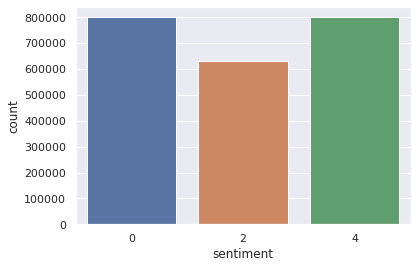

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(dataset.sentiment)

In [ ]:
tweets_data = np.array(dataset['text'])
label_data = np.array(dataset['sentiment'])

In [ ]:
#remove contractions
no_contract = []
for item in range(len(tweets_data)):
  try:
    no_contract.append(contractions.fix(tweets_data[item]))
  except IndexError:
    print(item)

1937039
2125775
2168108
2195239


In [ ]:
label_data = np.delete(label_data, [1937039,2125775,2168108,2195239])

In [ ]:
def remove_noise(tweet_tokens):
    # remove hyperlinks, special characters, emojis, punctuations
    
    for i in range(len(tweet_tokens)):
        tweet_tokens[i] = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                           '(?:%[0-9a-fA-F][0-9a-fA-F]))*', ' ', tweet_tokens[i])
        # Remove twitter handles
        tweet_tokens[i] = re.sub("(@[A-Za-z0-9_]*)"," ", tweet_tokens[i])
        # make lower
        tweet_tokens[i] = tweet_tokens[i].lower()
        tweet_tokens[i] = re.sub('\brt\b', ' ', tweet_tokens[i])
        tweet_tokens[i] = re.sub('[^\w\s]', ' ', tweet_tokens[i])
    return tweet_tokens

In [ ]:
no_noise = remove_noise(no_contract)

In [ ]:
no_noise[0]

'      awww  that is a bummer   you shoulda got david carr of third day to do it   d'

In [ ]:
tokenizer = RegexpTokenizer(r'\w+|[^\w\s]+')
tokenized = [tokenizer.tokenize(each) for each in no_noise]

In [ ]:
tokenized[2229560]

['tall', 'glass', 'of', 'water', 'by', 'tim', 'darcy', 'nowplaying', 'beats1']

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words=set(stopwords.words('english'))
stop_words.remove('not')

In [ ]:
def remove_stopwords(X):
  X_without_stopwords = []
  for sentence in X:
    temp = [word for word in sentence if not word in stop_words]
    X_without_stopwords.append(temp) 

  return X_without_stopwords

In [ ]:
no_stop = remove_stopwords(tokenized)

In [ ]:
no_stop[1]

['upset',
 'not',
 'update',
 'facebook',
 'texting',
 'might',
 'cry',
 'result',
 'school',
 'today',
 'also',
 'blah']

In [ ]:
#Lemmatization
nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'ner'])    

lengths = np.cumsum([0] + list(map(len, no_stop)))
print(lengths)

flat_words = [item for sublist in no_stop for item in sublist]
doc = spacy.tokens.Doc(nlp.vocab, words=flat_words)

lemmatized = []
# Iterate starting with 1
for index in range(1, len(lengths)):
    # Slice doc as described in the first point, so [0:3] and [3:6]
    span = doc[lengths[index - 1] : lengths[index]]
    # Add lemmatized tokens as list to the list
    lemmatized.append([token.lemma_ for token in span])

print(lemmatized[0])

[       0        8       20 ... 16913777 16913784 16913795]
['awww', 'bummer', 'shoulda', 'get', 'david', 'carr', '3', 'day']


In [ ]:
with open('/content/drive/MyDrive/newlemm.pickle', 'wb') as handle:
  pickle.dump(lemmatized, handle)

In [ ]:
clean_td = []

for sentence in lemmatized:
  temp = " ".join(sentence)
  clean_td.append(temp)

In [ ]:
max_vocab = 400000

In [ ]:
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(clean_td)

In [ ]:
with open('/content/drive/MyDrive/newtokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

In [ ]:
clean_vectorized=tokenizer.texts_to_sequences(clean_td)

In [ ]:
max_length = 25

In [ ]:
clean_pad = keras.preprocessing.sequence.pad_sequences(clean_vectorized,max_length,padding='post',
                                                         truncating='post')

print(clean_pad.shape)

(2229562, 25)


In [ ]:
# Visualize pre-processed data

index  = 1  # index in range [0,1599999]

print('\nOriginal :')
print(tweets_data[index])
print('\nTokenized :')
print(tokenized[index])
print('\nLemmatized :')
print(lemmatized[index])
print('\nClean :')
print(clean_td[index])
print('\nVectorized :')
print(clean_vectorized[index])
print('\nPadded :')
print(clean_pad[index])


Original :
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

Tokenized :
['is', 'upset', 'that', 'he', 'can', 'not', 'update', 'his', 'facebook', 'by', 'texting', 'it', 'and', 'might', 'cry', 'as', 'a', 'result', 'school', 'today', 'also', 'blah']

Lemmatized :
['upset', 'not', 'update', 'facebook', 'texting', 'may', 'cry', 'result', 'school', 'today', 'also', 'blah']

Clean :
upset not update facebook texting may cry result school today also blah

Vectorized :
[834, 1, 141, 376, 2400, 106, 313, 844, 82, 12, 222, 1421]

Padded :
[ 834    1  141  376 2400  106  313  844   82   12  222 1421    0    0
    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
# (0 = negative, 2 = neutral, 4 = positive) ==> (0 = negative, 1 = neutral, 2 = positive)
for idx in range(len(label_data)):
    if label_data[idx] == 2:
        label_data[idx] = 1
    elif label_data[idx] == 4:
        label_data[idx] = 2

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(clean_pad,label_data.reshape(label_data.shape[0],1),test_size=0.30)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1560693, 25)
(668869, 25)
(1560693, 1)
(668869, 1)


In [ ]:
# pickle

with open('/content/drive/MyDrive/newfsacd_x_train.pickle', 'wb') as handle:
    pickle.dump(X_train, handle)

with open('/content/drive/MyDrive/newfsacd_x_test.pickle', 'wb') as handle:
    pickle.dump(X_test, handle)
    
with open('/content/drive/MyDrive/newfsacd_y_train.pickle', 'wb') as handle:
    pickle.dump(Y_train, handle)
    
with open('/content/drive/MyDrive/newfsacd_y_test.pickle', 'wb') as handle:
    pickle.dump(Y_test, handle)

In [ ]:
# Load Pre-trained Word embeddings
embedding_path = '/content/drive/MyDrive/glove.6B.300d.txt'

embeddings_index = dict()
f = open(embedding_path, encoding='utf8')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()

# Create Word Embedding Matrix

embedding_matrix = np.zeros((max_vocab, 300))
for i in range(1,max_vocab):
	embedding_vector = embeddings_index.get(tokenizer.index_word[i])
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
with open('/content/drive/MyDrive/embmat.pickle', 'wb') as handle:
    pickle.dump(embedding_matrix, handle)